<a href="https://colab.research.google.com/github/colindbrown/methylation-hmm-rnn/blob/master/HMM_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports and helpers
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

np.set_printoptions(2)

def norm(x): 
    return(x/x.sum())

def row_norm(x):
    return x / x.sum(1, keepdims=True)

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# load data
scBSseq = np.load("/content/drive/My Drive/Colab Notebooks/methylation_hmm_rnn/scBSseq.npz")

meth_mat = scBSseq["meth_mat"] # positions x cells matrix of counts of methylated CpGs
unmeth_mat = scBSseq["unmeth_mat"] # positions x cells matrix of counts of unmethylated CpGs (i.e. C got converted to T)
positions = scBSseq["positions"] # genomic position of each CpG
chroms = scBSseq["chroms"] # chromomsome of each CpG
cell_names = scBSseq["cell_names"] # cell type and an arbitrary ID

total_counts = meth_mat + unmeth_mat
ncells_with_reads = (total_counts > 0).sum(1)

In [0]:
# initial data processing
pseudocount = 0.25

meth_level = ( meth_mat + pseudocount) / (total_counts + 2 * pseudocount)
meth_level = meth_level[ncells_with_reads >= 25,:] # only consider CpG positions with reads in 25 (out of 44) cells

meth_level_centered = meth_level - meth_level.mean(1, keepdims=True) # remove the per position mean

u,s,vh = np.linalg.svd(meth_level_centered, full_matrices=True) # needs high ram runtime

In [0]:
# Generic implementation of the forwards backwards algorithm
# "Generic" as it takes an O matrix of observation likelihoods rather than an explicit emission matrix
def forwards_generic(gamma0, T, O):
    '''
    Forward pass of the generic forwards-backwards algorithm.

    Params:
      gamma0 - initial distribution as vector of size K
      T      - transition matrix of size K x K
      O      - likelihood terms for observations: P(Y_t | X_t = k) K x S

    Returns:
      f      - S x K matrix: forward "messages" f[t,k] = P(x[t]=k | y[0:t]=y[0:t]) for 0<=k<K and 0<=t<S
    '''  
    S = O.shape[1]
    K = T.shape[0]
    f = np.ndarray((S,K))
    f[0] = norm(gamma0 * O[:,0])
    for i in range(1,S):
      f[i] = norm(O[:,i] * np.dot(f[i-1],T))
    return f

def backwards_generic(T, O):
    '''
    Backwards pass of the generic forwards-backwards algorithm. 

    Params:
      T      - transition matrix of size K x K
      O      - likelihood terms for observations: P(Y_t | X_t = k) K x S

    Returns:
      b      - S x K matrix: Backward "messages" b[t,k] = [P(y[t+1:n] | X[t]=k) for 0<=k<K and 1<=t<S      
    '''
    S = O.shape[1]
    K = T.shape[0]
    b = np.ndarray((S,K))
    b[S-1] = norm(np.ones(K))
    for i in reversed(range(0,S-1)):
      b[i,:] = norm(np.dot(T, b[i+1] * O[:,i+1]))
    return b

def forwards_backwards_generic(gamma0, T, O):
    '''
    Overall generic forwards-backwards algorithm. 

    Params:
      gamma0 - initial distribution as vector of size K
      T      - transition matrix of size K x K
      O      - likelihood terms for observations: P(Y_t | X_t = k) K x S

    Returns:
      gamma  - S x K matrix: posterior gamma[t,k] = P(X[t]=k | y[0:S])
      f      - S x K matrix: forward "messages"
                f[t,k] = P(x[t]=k | y[0:t]=y[0:t]) for 0<=k<K and 0<=t<S
      b      - S x K matrix: Backward "messages"
                b[t,k] = [P(y[t+1:n] | X[t]=k) for 0<=k<K and 1<=t<S      
    '''
    f = forwards_generic(gamma0, T, O) 
    b = backwards_generic(T, O)
    gamma = row_norm( f * b ) 
    return gamma, f, b

In [0]:
# wrapper to run forwards-backwards for a given T and E matrix
# calculates likelihoods using a binomial probability for methylation count
def forwards_backwards_binomial( meth_mat, unmeth_mat, gamma0, T, E ):
    logE = np.log1p(E-1)
    logCompE = np.log1p(-E)
    logO = np.matmul(logE, np.transpose(meth_mat)) + np.matmul(logCompE, np.transpose(unmeth_mat))
    logO -= logO.max(0,keepdims=True)
    O = np.exp(logO)
    
    gamma, f, b = forwards_backwards_generic(gamma0, T, O)
    return gamma, f, b, O

In [0]:
# EM using Baum-Welch algorithm 
def baum_welch_binomial(meth_mat, unmeth_mat, gamma0, E_init = None, T_init = None, tol=1e-4, maxIt = 100):
    '''
    Compute maximum likehood estimate using Expectation-Maximization

    Parameters:
    meth_mat    - S x L matrix of methylated counts
    unmeth_mat  - S x L matrix of unmethylated counts
    gamma0      - initial distribution of the hidden chain
    E_init      - Optional initialization of emission matrix E. 
    T_init      - Optional initialization of transition matrix T. 
    tol         - tolerance for the stopping criterion
    maxIt       - maximal number of iterations

    Returns:
    T           - K x K estimate of the transition matrix T[i,j] = P(X[t]=j | X[t-1]=i)
    E           - K x L estimate of the emission matrix E[i,j],
                  the binomial probability of methylation in cell j, given X[t]=i. 
  '''  
    K = gamma0.size
    L = meth_mat.shape[1]
    S = meth_mat.shape[0]
    
    # randomly initialize T, E
    T = row_norm( np.random.rand(K, K).astype(np.float32) ) if (T_init is None) else T_init
    E = 0.1 + 0.8 * np.random.rand(K,L) if (E_init is None) else E_init # avoid values too close to 0 or 1

    it = 0

    param_change = np.inf
    
    while (param_change > tol) and (it<maxIt):
        it += 1
        print("Iteration: %i Param change: %.3g" % (it, param_change))
        oldT = T.copy()
        oldE = E.copy()

        # E-step
        gamma, f, b, O = forwards_backwards_binomial(meth_mat, unmeth_mat, gamma0, T, E )

        # M-step 
        Tstar = np.zeros((K,K))
        for t in range(S-1):
            Tstar += norm( T * np.outer( f[t,:], O[:,t+1] * b[t+1,:] ) )
        T = row_norm(Tstar)

        gamma_meth = np.transpose(gamma) @ meth_mat + 1
        gamma_unmeth = np.transpose(gamma) @ unmeth_mat + 1
        E = gamma_meth / (gamma_meth + gamma_unmeth)
        
        param_change = max( np.abs(oldT-T).max() , np.abs(oldE-E).max() )

    return (T, E, gamma)

In [23]:
# Initialize and train HMM with masked training data
K = 10

E_init = vh[:K,:]
E_init -= E_init.min(1, keepdims=True)
E_init /= E_init.max(1, keepdims=True)
E_init = 0.8 * E_init + 0.1

T_init = row_norm(np.identity(K) + 1/K)

S = 30000

gamma0 = np.full(K,1/K)

test_meth = meth_mat[:S, :]
test_unmeth = unmeth_mat[:S, :]
test_total = test_meth + test_unmeth
to_mask = test_total >= 2
print(to_mask.mean()) # % of data testing on
test_meth_masked = test_meth.copy() 
test_meth_masked[to_mask] = 0
test_unmeth_masked = test_unmeth.copy() 
test_unmeth_masked[to_mask] = 0

T,E,gamma = baum_welch_binomial( test_meth_masked, test_unmeth_masked, gamma0, E_init = E_init, T_init = T_init, tol = 0.01 )

0.13284242424242423
Iteration: 1 Param change: inf
Iteration: 2 Param change: 0.754
Iteration: 3 Param change: 0.269
Iteration: 4 Param change: 0.328
Iteration: 5 Param change: 0.248
Iteration: 6 Param change: 0.104
Iteration: 7 Param change: 0.0756
Iteration: 8 Param change: 0.0741
Iteration: 9 Param change: 0.0743
Iteration: 10 Param change: 0.0678
Iteration: 11 Param change: 0.0603
Iteration: 12 Param change: 0.0422
Iteration: 13 Param change: 0.0343
Iteration: 14 Param change: 0.0257
Iteration: 15 Param change: 0.0221
Iteration: 16 Param change: 0.0239
Iteration: 17 Param change: 0.0245
Iteration: 18 Param change: 0.0242
Iteration: 19 Param change: 0.0237
Iteration: 20 Param change: 0.0225
Iteration: 21 Param change: 0.0207
Iteration: 22 Param change: 0.0186
Iteration: 23 Param change: 0.0185
Iteration: 24 Param change: 0.0185
Iteration: 25 Param change: 0.0175
Iteration: 26 Param change: 0.0159
Iteration: 27 Param change: 0.014
Iteration: 28 Param change: 0.012
Iteration: 29 Param

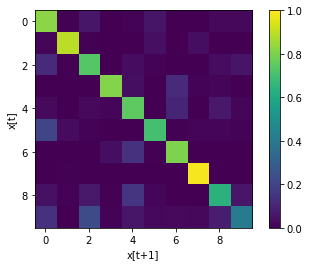

In [9]:
# display learned transition matrix
plt.imshow(T,vmin=0, vmax=1)
plt.colorbar()
plt.ylabel("Hidden state")
plt.xlabel("x[t+1]")
_ = plt.ylabel("x[t]")

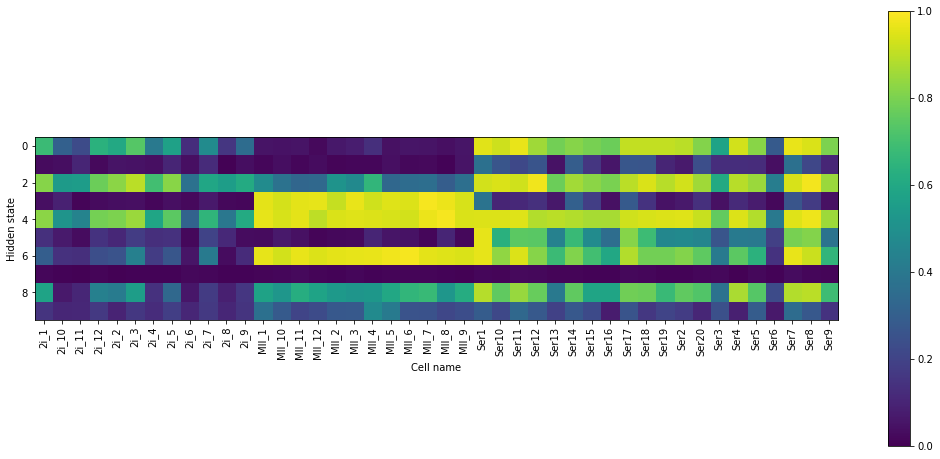

In [10]:
# display learned emission matrix
plt.figure(figsize=(18,8))
plt.imshow(E, vmin=0, vmax=1)
_ = plt.xticks(np.arange(len(cell_names)), cell_names, rotation="vertical")
plt.colorbar()
plt.xlabel("Cell name")
_ = plt.ylabel("Hidden state")

In [11]:
# test using masked data and print accuracy
Y_pred = np.matmul(gamma, E)
Y_obs = test_meth / test_total
Y_pred[to_mask] - Y_pred[to_mask]
correct_pred = (Y_obs[to_mask]>.5) == (Y_pred[to_mask]>.5)
correct_pred.mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


0.878518636799124

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


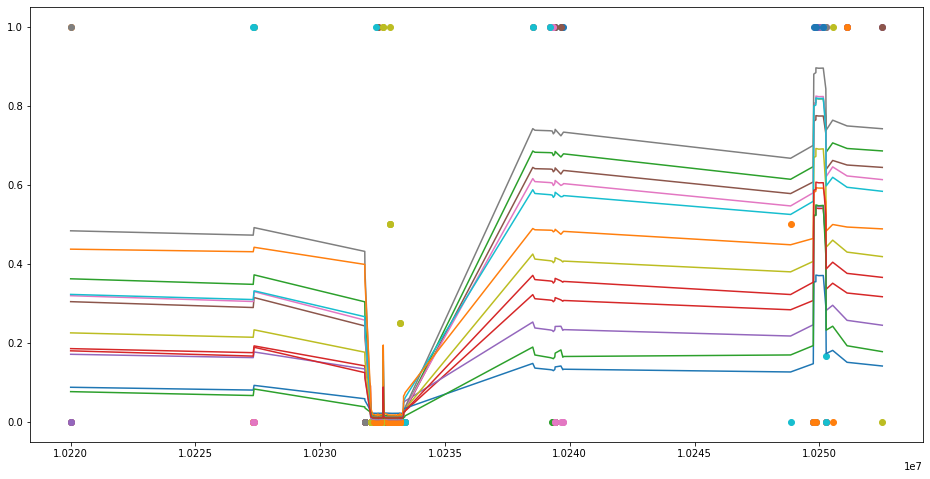

In [13]:
# visualize emission across genome around CpG island
(cpg_start,cpg_end) = (10232143, 10233428)

window = 20000

in_cpg = np.logical_and( chroms == "1" , np.logical_and( cpg_start - window < positions , positions < cpg_end + window ))

meth_mat[in_cpg,:]
unmeth_mat[in_cpg,:]

y = meth_mat[in_cpg,:] / ( unmeth_mat[in_cpg,:] + meth_mat[in_cpg,:] )

plt.figure(figsize=(16,8))
_ = plt.plot( positions[in_cpg], y[:,:12], "o")
_ = plt.plot( positions[in_cpg], Y_pred[in_cpg[:S],:12], "-")